In [ ]:
!pip install google-cloud-aiplatform google-cloud-storage
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Attention, Input
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from datetime import datetime,timedelta
import gc
import psutil
from tensorflow import keras

In [ ]:
from google.cloud import storage

BUCKET_NAME = "gold_predictions_web"  # ‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÄ‡∏õ‡πá‡∏ô‡∏ä‡∏∑‡πà‡∏≠ Bucket ‡∏Ç‡∏≠‡∏á‡∏Ñ‡∏∏‡∏ì

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
print(f"‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏ï‡πà‡∏≠‡∏Å‡∏±‡∏ö GCS Bucket: {BUCKET_NAME}")

‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏ï‡πà‡∏≠‡∏Å‡∏±‡∏ö GCS Bucket: gold_predictions_web


In [ ]:
import requests
nowDate=datetime.now()
startTime=f'{nowDate.year-10}-{nowDate.month}-{nowDate.day}'
endTime=f'{nowDate.year}-{nowDate.month}-{nowDate.day}'
startTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year-10}'
endTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year}'
url_currency = f"https://gold-predictions.duckdns.org/currency/get/?start={startTime}&end={endTime}&cache=False"
url_Gold_usd = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=1&start={startTime_1}&end={endTime_1}&cache=False"
url_Gold_thb = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=0&start={startTime_1}&end={endTime_1}&cache=False"
# ‡πÄ‡∏£‡∏µ‡∏¢‡∏Å API ‡πÅ‡∏•‡∏∞‡∏î‡∏∂‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
response = requests.get(url_currency)

# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏Å‡∏≤‡∏£‡πÄ‡∏£‡∏µ‡∏¢‡∏Å API ‡∏™‡∏≥‡πÄ‡∏£‡πá‡∏à‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
if response.status_code == 200:
    data_currency = response.json()  # ‡πÅ‡∏õ‡∏•‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô JSON
    data_list = data_currency["data"]
    df_currency = pd.DataFrame(data_list)  # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame
    print(df_currency.tail())  # ‡πÅ‡∏™‡∏î‡∏á‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_usd)

# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏Å‡∏≤‡∏£‡πÄ‡∏£‡∏µ‡∏¢‡∏Å API ‡∏™‡∏≥‡πÄ‡∏£‡πá‡∏à‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
if response.status_code == 200:
    data_Gold_usd = response.json()  # ‡πÅ‡∏õ‡∏•‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô JSON
    data_list = data_Gold_usd["data"]
    df_Gold_usd = pd.DataFrame(data_list)  # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame
    print(df_Gold_usd.tail())  # ‡πÅ‡∏™‡∏î‡∏á‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_thb)

# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏Å‡∏≤‡∏£‡πÄ‡∏£‡∏µ‡∏¢‡∏Å API ‡∏™‡∏≥‡πÄ‡∏£‡πá‡∏à‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà
if response.status_code == 200:
    data_Gold_thb = response.json()  # ‡πÅ‡∏õ‡∏•‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô JSON
    data_list = data_Gold_thb["data"]
    df_Gold_thb = pd.DataFrame(data_list)  # ‡∏™‡∏£‡πâ‡∏≤‡∏á DataFrame
    print(df_Gold_thb.tail())  # ‡πÅ‡∏™‡∏î‡∏á‡∏ï‡∏±‡∏ß‡∏≠‡∏¢‡πà‡∏≤‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
else:
    print(f"Error: {response.status_code}")

df_currency=df_currency[['date','price']]
df_currency.columns = ['Date', 'price_exchange']

df_Gold_thb=df_Gold_thb[['timestamp','price']]
df_Gold_thb = df_Gold_thb.copy()
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_thb['timestamp'] = pd.to_datetime(df_Gold_thb['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_thb.columns = ['Date', 'Thai_Gold']

df_Gold_usd=df_Gold_usd[['timestamp','close_price']]
df_Gold_usd = df_Gold_usd.copy()
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_usd['timestamp'] = pd.to_datetime(df_Gold_usd['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_usd.columns = ['Date', 'Xau']


# ‡∏£‡∏ß‡∏° DataFrame ‡∏ó‡∏±‡πâ‡∏á‡∏™‡∏≤‡∏°‡πÇ‡∏î‡∏¢‡πÉ‡∏ä‡πâ date ‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡∏µ‡∏¢‡πå‡∏≠‡πâ‡∏≤‡∏á‡∏≠‡∏¥‡∏á
df_currency['Date'] = pd.to_datetime(df_currency['Date'], format='%Y-%m-%d').dt.normalize()
df_Gold_thb['Date'] = pd.to_datetime(df_Gold_thb['Date'], format='%d/%m/%Y').dt.normalize()
df_Gold_usd['Date'] = pd.to_datetime(df_Gold_usd['Date'], format='%d/%m/%Y').dt.normalize()
merged_df = (
    df_Gold_thb
    .merge(df_Gold_usd, on='Date', how='outer')
    .merge(df_currency, on='Date', how='outer')
)
merged_df = (
    merged_df
    .sort_values('Date')
    .groupby('Date', as_index=False)
    .first()  # ‡πÄ‡∏≠‡∏≤‡πÅ‡∏ñ‡∏ß‡πÅ‡∏£‡∏Å‡∏Ç‡∏≠‡∏á‡πÅ‡∏ï‡πà‡∏•‡∏∞‡∏ß‡∏±‡∏ô
)
print(df_currency.dtypes)
print(df_Gold_thb.dtypes)
print(df_Gold_usd.dtypes)

merged_df[['Xau']] = merged_df[['Xau']].shift(1)
merged_df['Xau'] = merged_df['Xau'].ffill()
merged_df.dropna(inplace=True)
merged_df.to_csv('acvs.csv')
dupes = merged_df[merged_df.duplicated('Date', keep=False)]
print(f"‡∏à‡∏≥‡∏ô‡∏ß‡∏ô‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏ã‡πâ‡∏≥: {len(dupes)}")
print(dupes.sort_values('Date'))

          id        date  price   open   high    low  percent  diff
6882  194970  2025-04-19  33.39  33.35  33.45  33.32     0.11  0.04
6883  194971  2025-04-20  33.38  33.39  33.44  33.31    -0.04 -0.01
6884  194972  2025-04-21  33.06  33.35  33.35  33.03    -0.96 -0.32
6885  194973  2025-04-22  33.44  33.06  33.48  33.04     1.15  0.38
6886  194974  2025-04-23  33.52  33.37  33.67  33.28     0.24  0.08
         id      timestamp    price  close_price  high_price  low_price  \
3040  90319  1744588800000  3221.80      3212.34     3245.23    3194.59   
3041  90320  1744675200000  3212.71      3250.51     3250.80    3210.20   
3042  90323  1744761600000  3252.86      3349.52     3357.01    3250.34   
3043  90325  1744848000000  3349.87      3314.93     3355.33    3276.44   
3044  90326  1745280000000  3471.10      3479.42     3499.45    3466.80   

      volume  volume_weight_avg  num_transactions      date  \
3040  3542.0          3218.3421              3542  14-04-25   
3041  3592.0   

In [ ]:
merged_df

Date  Thai_Gold      Xau  price_exchange
1    2015-04-24    18300.0  1193.76         32.5600
2    2015-04-25    18150.0  1178.91         32.5733
4    2015-04-27    18250.0  1179.88         32.6000
5    2015-04-28    18450.0  1199.80         32.6300
6    2015-04-29    18600.0  1211.59         32.8400
...         ...        ...      ...             ...
3648 2025-04-18    52350.0  3314.93         33.3500
3649 2025-04-19    52350.0  3314.93         33.3900
3651 2025-04-21    52900.0  3314.93         33.0600
3652 2025-04-22    54550.0  3314.93         33.4400
3653 2025-04-23    53000.0  3479.42         33.5200

[3081 rows x 4 columns]

In [ ]:
df_currency.tail()

Date  price_exchange
6882 2025-04-19           33.39
6883 2025-04-20           33.38
6884 2025-04-21           33.06
6885 2025-04-22           33.44
6886 2025-04-23           33.52

lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 31ms/step


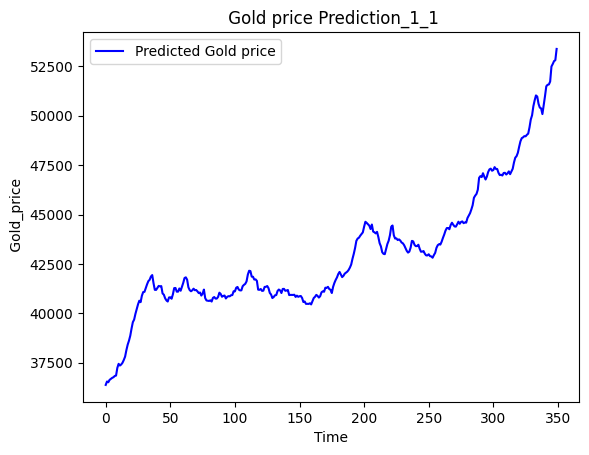

Future = 1
lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 28ms/step


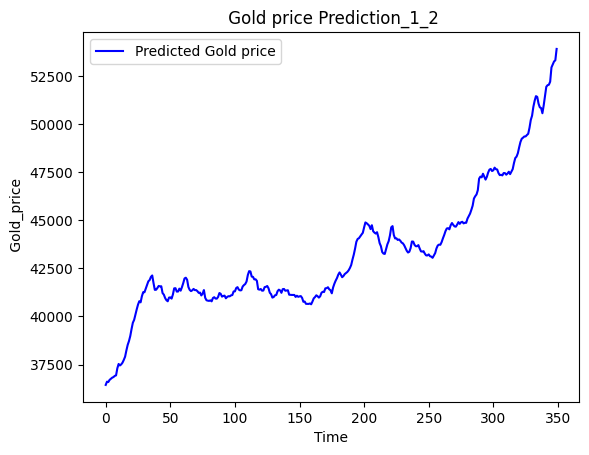

Future = 2
lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 29ms/step


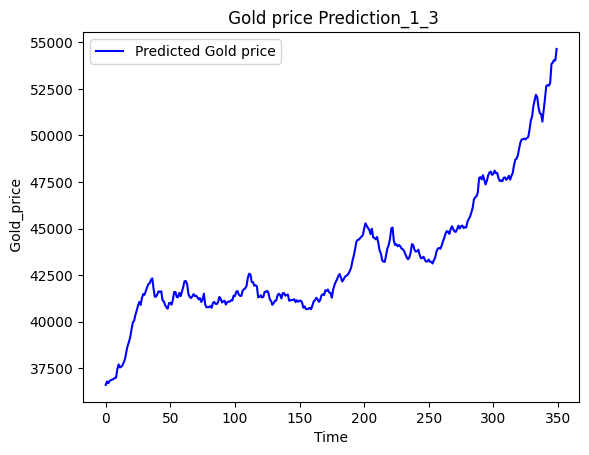

Future = 3
lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 27ms/step


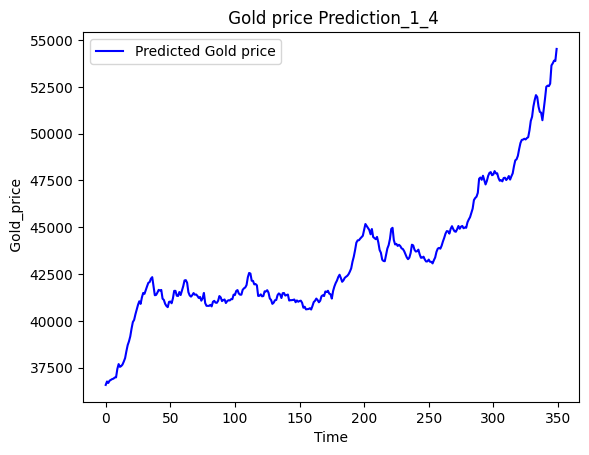

Future = 4
lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 30ms/step


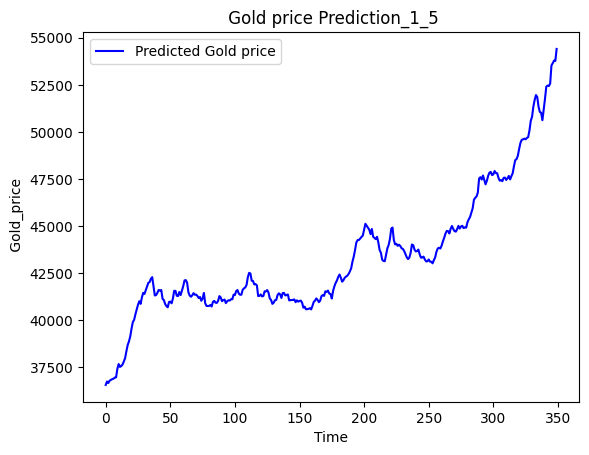

Future = 5
lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 28ms/step


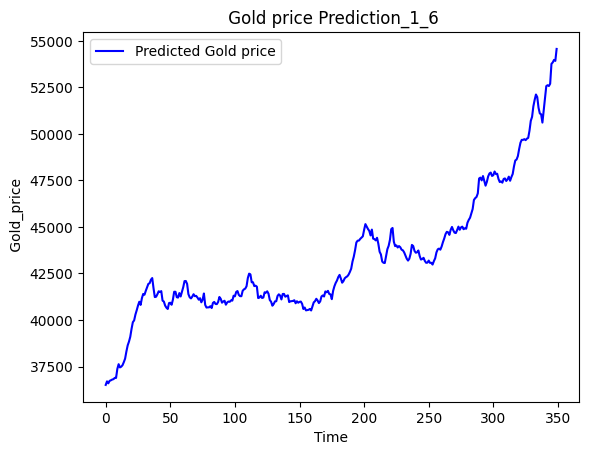

Future = 6
lag=1
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 28ms/step


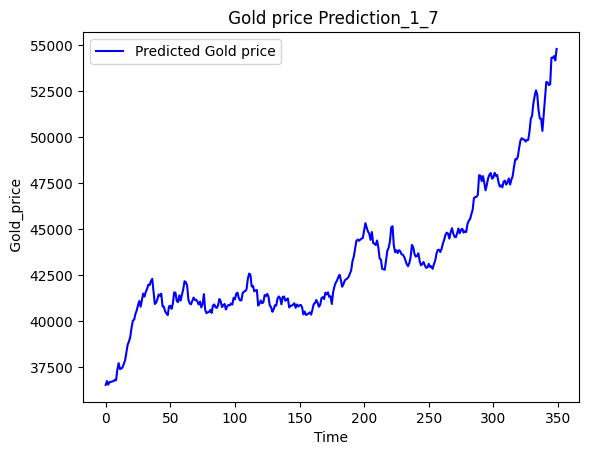

Future = 7


In [ ]:

seq = [1,1,1,1,1,1,1]
fut = [1,2,3,4,5,6,7]
movingavg=[2,2,1,1,1,1,0]
lag=[1,1,1,1,1,1,1]
dateonoff=[False,False,False,False,False,False,False]
predictArray=[]
base_path = "/content/model"
# folder_path = os.path.join(base_path, f"folder_{current_time}")
# os.makedirs(folder_path, exist_ok=True)
for indexfut in range(len(fut)):
          data = merged_df.copy()
          data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
          if dateonoff[indexfut] == True:
            data['Day_of_week'] = data['Date'].dt.day_name()
            data['Day'] = data['Date'].dt.day
            data['Month'] = data['Date'].dt.month
            data = pd.get_dummies(data, columns=['Day_of_week'], drop_first=True)

          if movingavg[indexfut] >=4:
            data['MA_20'] = data['Thai_Gold'].ewm(span=20, adjust=True).mean()
          if movingavg[indexfut] >=3:
            data['MA_14'] = data['Thai_Gold'].ewm(span=14, adjust=False).mean()
          if movingavg[indexfut] >=2:
            data['MA_10'] = data['Thai_Gold'].ewm(span=10, adjust=True).mean()
          if movingavg[indexfut] >=1:
            data['MA_7'] = data['Thai_Gold'].ewm(span=7, adjust=False).mean()
          data.dropna(inplace=True)

          target = 'Thai_Gold'
          data_clone=data
          X = data.drop(columns=['Thai_Gold','Date'])
          y = data[target].values
          for i in range(1, lag[indexfut]+1):  # ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á 7 ‡∏ß‡∏±‡∏ô
              print(f'lag={i}')
              X[f'Thai_Gold_Lag_{i}'] = data_clone['Thai_Gold'].shift(i)
          X = X.dropna().reset_index(drop=True)
          y=y.reshape(-1, 1)
          y = np.array(y, dtype=np.float64)
          y = y[lag[indexfut]:]
          dataframe_y=y
          dataframe_x=X
          X=X.values
          scaler_X = MinMaxScaler(feature_range=(0,1))
          scaler_y = MinMaxScaler(feature_range=(0,1))
          X = scaler_X.fit_transform(X)
          y = scaler_y.fit_transform(y)

          def createXY(DataX,n_past):
              dataX = []
              dataY = []
              for i in range(n_past, len(DataX)):
                  dataX.append(DataX[i - n_past:i,:])  # ‡∏î‡∏∂‡∏á‡∏ó‡∏∏‡∏Å‡∏ü‡∏µ‡πÄ‡∏à‡∏≠‡∏£‡πå (‡∏ó‡∏∏‡∏Å‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå)
              return np.array(dataX)

          lookback = seq[indexfut]  # ‡∏î‡∏π‡∏¢‡πâ‡∏≠‡∏ô‡∏´‡∏•‡∏±‡∏á 30 ‡∏ß‡∏±‡∏ô
          X_seq= createXY(X,lookback)

          # ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
          test_size = 350     # ‡∏Ç‡∏ô‡∏≤‡∏î Test Set
          val_size = 350      # ‡∏Ç‡∏ô‡∏≤‡∏î Validation Set
          train_size = X_seq.shape[0] - (val_size + test_size)  # ‡∏Ç‡∏ô‡∏≤‡∏î Training Set

          # ‡πÅ‡∏ö‡πà‡∏á‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•‡πÄ‡∏õ‡πá‡∏ô Training, Validation ‡πÅ‡∏•‡∏∞ Test ‡∏ï‡∏≤‡∏°‡∏•‡∏≥‡∏î‡∏±‡∏ö‡πÄ‡∏ß‡∏•‡∏≤
          X_train = X_seq[:train_size]
          X_val = X_seq[train_size:train_size + val_size]
          X_test = X_seq[train_size + val_size:]

          #           # ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏Ç‡∏ô‡∏≤‡∏î‡∏Ç‡∏≠‡∏á‡∏ä‡∏∏‡∏î‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
          # print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
          # print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
          # print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

          MODEL_NAME = f"Future_{fut[indexfut]}.keras"     # ‡πÄ‡∏õ‡∏•‡∏µ‡πà‡∏¢‡∏ô‡πÄ‡∏õ‡πá‡∏ô‡∏ä‡∏∑‡πà‡∏≠‡πÑ‡∏ü‡∏•‡πå‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡πÇ‡∏´‡∏•‡∏î
          DESTINATION_DIR = "models"        # ‡πÇ‡∏ü‡∏•‡πÄ‡∏î‡∏≠‡∏£‡πå‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£‡πÄ‡∏Å‡πá‡∏ö‡πÇ‡∏°‡πÄ‡∏î‡∏•‡πÉ‡∏ô‡πÄ‡∏Ñ‡∏£‡∏∑‡πà‡∏≠‡∏á
          os.makedirs(DESTINATION_DIR, exist_ok=True)
          destination_path = os.path.join(DESTINATION_DIR, MODEL_NAME)
          blob = bucket.blob(f'models/{MODEL_NAME}')
          blob.download_to_filename(destination_path)
          # ‡πÇ‡∏´‡∏•‡∏î‡∏Å‡∏•‡∏±‡∏ö‡∏°‡∏≤‡πÉ‡∏ä‡πâ‡∏á‡∏≤‡∏ô
          model = keras.models.load_model(destination_path)
            # ‡∏ó‡∏≥‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢
          prediction=model.predict(X_test)

            # ‡πÅ‡∏õ‡∏•‡∏á‡∏ú‡∏•‡∏Å‡∏≤‡∏£‡∏ó‡∏≥‡∏ô‡∏≤‡∏¢‡πÅ‡∏•‡∏∞‡∏Ñ‡πà‡∏≤‡∏à‡∏£‡∏¥‡∏á‡∏Å‡∏•‡∏±‡∏ö‡πÑ‡∏õ‡πÄ‡∏õ‡πá‡∏ô‡∏Ñ‡πà‡∏≤‡πÄ‡∏î‡∏¥‡∏° (inverse scaling)
          predict_ori=scaler_y.inverse_transform(prediction)
          # actual_ori=scaler_y.inverse_transform(y_test)

          # plt.plot(actual_ori, color = 'red', label = 'Real  Gold Price')
          plt.plot(predict_ori, color = 'blue', label = 'Predicted Gold price')
          plt.title(f' Gold price Prediction_{seq[indexfut]}_{fut[indexfut]}')
          plt.xlabel('Time')
          plt.ylabel(' Gold_price')
          plt.legend()
          plt.show()
          if fut[indexfut] == 1:
            df_predict_1 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 2:
            df_predict_2 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 3:
            df_predict_3 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 4:
            df_predict_4 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 5:
            df_predict_5 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 6:
            df_predict_6 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 7:
            df_predict_7 = pd.DataFrame(predict_ori, columns=['price'])
          # df_predict.to_csv(f'Future abc = {fut[indexfut]}.csv',index=False)
          print(f"Future = {fut[indexfut]}")
          del model
          gc.collect()


In [ ]:
df_last_350 = merged_df.tail(350)

In [ ]:
df_last_350.to_csv('abc12.csv')

In [ ]:
df_last_350=df_last_350['Date'].reset_index(drop=True)

In [ ]:
df_last_350

0     2024-03-12
1     2024-03-13
2     2024-03-14
3     2024-03-15
4     2024-03-16
         ...    
345   2025-04-18
346   2025-04-19
347   2025-04-21
348   2025-04-22
349   2025-04-23
Name: Date, Length: 350, dtype: datetime64[ns]

In [ ]:
df_predict_1

price
0    36369.941406
1    36544.105469
2    36504.417969
3    36625.628906
4    36677.570312
..            ...
345  52495.300781
346  52621.472656
347  52768.792969
348  52813.054688
349  53385.535156

[350 rows x 1 columns]

In [ ]:
from datetime import datetime
import time
# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤ df_last_350 ‡πÄ‡∏õ‡πá‡∏ô DataFrame
df_last_350 = df_last_350.to_frame() if isinstance(df_last_350, pd.Series) else df_last_350

# ‡∏ï‡∏£‡∏ß‡∏à‡∏™‡∏≠‡∏ö‡∏ß‡πà‡∏≤‡∏°‡∏µ‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå price_1 ‡∏ñ‡∏∂‡∏á price_7 ‡∏´‡∏£‡∏∑‡∏≠‡πÑ‡∏°‡πà ‡∏ñ‡πâ‡∏≤‡πÑ‡∏°‡πà‡∏°‡∏µ‡πÉ‡∏´‡πâ‡∏™‡∏£‡πâ‡∏≤‡∏á
column_names = [f'price_{i+1}' for i in range(7)]
for col in column_names:
    if col not in df_last_350.columns:
        df_last_350[col] = np.nan  # ‡πÉ‡∏™‡πà‡∏Ñ‡πà‡∏≤ NaN ‡∏ñ‡πâ‡∏≤‡∏¢‡∏±‡∏á‡πÑ‡∏°‡πà‡∏°‡∏µ‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå
# ‡πÅ‡∏õ‡∏•‡∏á df_predict_x ‡πÄ‡∏õ‡πá‡∏ô DataFrame ‡πÅ‡∏•‡∏∞‡∏£‡∏µ‡πÄ‡∏ã‡πá‡∏ï index ‡∏Å‡πà‡∏≠‡∏ô‡πÄ‡∏û‡∏¥‡πà‡∏°‡πÄ‡∏Ç‡πâ‡∏≤ df_last_350
df_last_350['price_1'] = df_predict_1['price'].reset_index(drop=True)
df_last_350['price_2'] = df_predict_2['price'].reset_index(drop=True)
df_last_350['price_3'] = df_predict_3['price'].reset_index(drop=True)
df_last_350['price_4'] = df_predict_4['price'].reset_index(drop=True)
df_last_350['price_5'] = df_predict_5['price'].reset_index(drop=True)
df_last_350['price_6'] = df_predict_6['price'].reset_index(drop=True)
df_last_350['price_7'] = df_predict_7['price'].reset_index(drop=True)

import pytz

# ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡πÇ‡∏ã‡∏ô‡πÄ‡∏ß‡∏•‡∏≤ Indochina (ICT, UTC+7)
indochina_tz = pytz.timezone('Asia/Bangkok')

# ‡πÄ‡∏ß‡∏•‡∏≤‡∏õ‡∏±‡∏à‡∏à‡∏∏‡∏ö‡∏±‡∏ô‡πÉ‡∏ô UTC
current_utc_time = datetime.utcnow().replace(tzinfo=pytz.utc)

# ‡πÄ‡∏ß‡∏•‡∏≤‡∏õ‡∏±‡∏à‡∏à‡∏∏‡∏ö‡∏±‡∏ô‡πÉ‡∏ô Indochina Time (ICT, UTC+7)
current_ict_time = current_utc_time.astimezone(indochina_tz)

# ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô Unix Timestamp (‡∏ß‡∏¥‡∏ô‡∏≤‡∏ó‡∏µ)
current_unix_time = int(time.time())

# ‡∏õ‡∏£‡∏±‡∏ö‡∏ü‡∏≠‡∏£‡πå‡πÅ‡∏°‡∏ï‡∏Ç‡∏≠‡∏á Timestamp ICT ‡πÉ‡∏´‡πâ‡πÄ‡∏õ‡πá‡∏ô `YYYY-MM-DD HH:MM:SS.SSS +0700`
timestamp_ict_formatted = current_ict_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] + " +0700"

# ‡πÄ‡∏û‡∏¥‡πà‡∏°‡∏Ñ‡∏≠‡∏•‡∏±‡∏°‡∏ô‡πå‡∏•‡∏á‡πÉ‡∏ô df_last_350
df_last_350 = df_last_350.assign(
    timestamp=current_unix_time,  # Unix Timestamp (UTC)
    created_at=timestamp_ict_formatted  # Timestamp ICT ‡πÅ‡∏ö‡∏ö‡∏ü‡∏≠‡∏£‡πå‡πÅ‡∏°‡∏ï‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£
)
df_last_350.rename(columns={"Date": "date"}, inplace=True)
def get_next_weekdays(start_date, count):
    result = []
    current = start_date
    while len(result) < count:
        current += pd.Timedelta(days=1)
        if current.weekday() != 6:  # ‡πÑ‡∏°‡πà‡πÉ‡∏ä‡πà‡∏ß‡∏±‡∏ô‡∏≠‡∏≤‡∏ó‡∏¥‡∏ï‡∏¢‡πå (Sunday = 6)
            result.append(current)
    return result
for i in range(1, 8):
    df_last_350[f'date_{i}'] = df_last_350['date'].apply(lambda d: get_next_weekdays(d, 7)[i-1])
# df_last_350["date"] = pd.to_datetime(df_last_350["date"])  # ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô datetime64
# df_last_350["timestamp"] = df_last_350["date"].astype("int64") // 10**9  # ‡πÅ‡∏õ‡∏•‡∏á‡πÄ‡∏õ‡πá‡∏ô Unix timestamp (‡∏ß‡∏¥‡∏ô‡∏≤‡∏ó‡∏µ)
df_last_350["date"] = df_last_350["date"].astype(str).str[:16]  # ‡∏ï‡∏±‡∏î‡πÉ‡∏´‡πâ‡πÑ‡∏°‡πà‡πÄ‡∏Å‡∏¥‡∏ô 16 ‡∏ï‡∏±‡∏ß‡∏≠‡∏±‡∏Å‡∏©‡∏£
for i in range(1, 8):
    df_last_350[f'date_{i}'] = df_last_350[f'date_{i}'].astype(str).str[:16]
# ‡πÅ‡∏™‡∏î‡∏á‡∏ú‡∏•‡∏•‡∏±‡∏û‡∏ò‡πå
df_last_350=df_last_350.iloc[[-1]]
print(df_last_350.head())
df_last_350.to_csv('abc.csv')


           date       price_1       price_2       price_3       price_4  \
349  2025-04-23  53385.535156  53908.675781  54647.054688  54528.585938   

          price_5       price_6       price_7   timestamp  \
349  54404.707031  54564.574219  54798.839844  1745432192   

                        created_at      date_1      date_2      date_3  \
349  2025-04-24 01:16:32.878 +0700  2025-04-24  2025-04-25  2025-04-26   

         date_4      date_5      date_6      date_7  
349  2025-04-28  2025-04-29  2025-04-30  2025-05-01  


In [ ]:
!pip install psycopg2-binary sqlalchemy


In [ ]:
from sqlalchemy import create_engine
# ‡πÅ‡∏õ‡∏•‡∏á date ‡πÄ‡∏õ‡πá‡∏ô datetime
df= pd.to_datetime(merged_df["Date"])
df = df.to_frame()

# ‡∏î‡∏∂‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏•‡πà‡∏≤‡∏™‡∏∏‡∏î‡∏à‡∏≤‡∏Å DataFrame
last_date = df["Date"].max().date()  # ‡πÄ‡∏≠‡∏≤‡πÄ‡∏â‡∏û‡∏≤‡∏∞‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà (‡πÑ‡∏°‡πà‡πÄ‡∏≠‡∏≤‡πÄ‡∏ß‡∏•‡∏≤)

# ‡∏î‡∏∂‡∏á‡∏ß‡∏±‡∏ô‡∏ó‡∏µ‡πà‡∏õ‡∏±‡∏à‡∏à‡∏∏‡∏ö‡∏±‡∏ô
today = datetime.now().date()
if last_date == today:
# üîπ ‡∏Å‡∏≥‡∏´‡∏ô‡∏î‡∏Ñ‡πà‡∏≤‡∏Å‡∏≤‡∏£‡πÄ‡∏ä‡∏∑‡πà‡∏≠‡∏°‡∏ï‡πà‡∏≠ PostgreSQL
  DB_USER = "postgres"  # ‡∏ä‡∏∑‡πà‡∏≠‡∏ú‡∏π‡πâ‡πÉ‡∏ä‡πâ PostgreSQL
  DB_PASSWORD = "postgres"  # ‡∏£‡∏´‡∏±‡∏™‡∏ú‡πà‡∏≤‡∏ô
  DB_HOST = "34.133.61.28"  # ‡∏õ‡∏Å‡∏ï‡∏¥‡πÉ‡∏ä‡πâ "localhost" ‡∏´‡∏£‡∏∑‡∏≠ IP ‡∏Ç‡∏≠‡∏á‡πÄ‡∏ã‡∏¥‡∏£‡πå‡∏ü‡πÄ‡∏ß‡∏≠‡∏£‡πå
  DB_PORT = "5432"  # ‡∏û‡∏≠‡∏£‡πå‡∏ï‡πÄ‡∏£‡∏¥‡πà‡∏°‡∏ï‡πâ‡∏ô‡∏Ç‡∏≠‡∏á PostgreSQL
  DB_NAME = "postgres"  # ‡∏ä‡∏∑‡πà‡∏≠‡∏ê‡∏≤‡∏ô‡∏Ç‡πâ‡∏≠‡∏°‡∏π‡∏•
  TABLE_NAME = "predicts_week"  # ‡∏ä‡∏∑‡πà‡∏≠‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡∏ó‡∏µ‡πà‡∏ï‡πâ‡∏≠‡∏á‡∏Å‡∏≤‡∏£ INSERT

    # üîπ ‡∏™‡∏£‡πâ‡∏≤‡∏á Connection ‡πÑ‡∏õ‡∏¢‡∏±‡∏á PostgreSQL ‡∏î‡πâ‡∏ß‡∏¢ SQLAlchemy
  engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
    # df_last_350['created_at'] = pd.to_datetime(df_last_350['created_at']).dt.tz_convert('Asia/Bangkok')

    # üîπ Insert DataFrame ‡∏•‡∏á‡πÉ‡∏ô PostgreSQL (‡∏ñ‡πâ‡∏≤‡∏ï‡∏≤‡∏£‡∏≤‡∏á‡πÑ‡∏°‡πà‡∏°‡∏µ‡πÉ‡∏´‡πâ‡∏™‡∏£‡πâ‡∏≤‡∏á‡∏≠‡∏±‡∏ï‡πÇ‡∏ô‡∏°‡∏±‡∏ï‡∏¥)
  df_last_350.to_sql(TABLE_NAME, engine, if_exists="append", index=False)

  print(f"‚úÖ Insert DataFrame ‡∏•‡∏á‡πÉ‡∏ô PostgreSQL ‡∏ï‡∏≤‡∏£‡∏≤‡∏á {TABLE_NAME} ‡∏™‡∏≥‡πÄ‡∏£‡πá‡∏à!")


‚úÖ Insert DataFrame ‡∏•‡∏á‡πÉ‡∏ô PostgreSQL ‡∏ï‡∏≤‡∏£‡∏≤‡∏á predicts_week ‡∏™‡∏≥‡πÄ‡∏£‡πá‡∏à!
